In [424]:
import urllib.request
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import sys,os,glob
from pandas import HDFStore
from threading import Thread
from datetime import  datetime,timedelta
width = 13
base_link = "http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/09_2019/"
%matplotlib inline

In [371]:
class obrabotka_danniy(object):
#-----------------------------------------------------------------------------------------------------------------------      

    @staticmethod
    def get_all_links_file(base_link=base_link):
        page = requests.get(base_link)
        soup = BeautifulSoup(page.content)
        result = []
        for link in soup.find_all('a', href=True):
            if (link['href'][-4]=='.' and link['href'][-1]=='B'):
                result.append(base_link + link['href'])
        return result

    @staticmethod
    def create_dir_for_downloading_files(base_link=base_link):
        path = os.path.abspath('') + '\\' + str(base_link.split('/')[-2])
        if not os.path.isdir(path):
            os.mkdir(path)
            return path
        else:
            return path
            
    @staticmethod
    def download_files(urls=None):
        if urls==None:
            urls = ["http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/10_2019/10010008.19B",
                     "http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/10_2019/10010018.19B",
                       "http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/06_2019/06010030.19R"]
        for i,j in enumerate(urls):
            handle = urllib.request.urlopen(urls[i])
            #создаем папку с названием выбранной папки (нап: "09_2019")
            dir_name = obrabotka_danniy.create_dir_for_downloading_files()
            fname = os.path.basename(urls[i])
            full_name =os.path.join(dir_name,os.path.basename(urls[i]))
            with open(full_name, "wb") as f_handler:
                while True:
                    chunk = handle.read()
                    if not chunk:
                        break
                    f_handler.write(chunk)
                    
    @staticmethod
    def get_file_names_in_dir(directory="09_2019"):
        file_names = []
        file_name = os.path.join(os.path.abspath(''),directory)
        for i in glob.glob(file_name +"\\" + "*.19B"):
            file_names.append(i)
        return file_names

    @staticmethod
    def function_obrabotka(default=0):
        data_frame_list = []
        if default==1:
            file_names = get_file_names_in_dir()
        file_names = get_file_names_in_dir()
        with pd.HDFStore('data_base.h5',  mode='w') as store:
            for i,j in enumerate(file_names):
                with open(j, "rb") as file:
                    content = file.read()
                    data_dopolnitelniy = np.frombuffer(content[:17], dtype=np.dtype('i1'))
                    data_dopolnitelniy = np.frombuffer(data_dopolnitelniy[:16], dtype=np.dtype('i2'))
                    date_temp = data_dopolnitelniy[:-1]
                    date_time = datetime(*date_temp).strftime("%d.%m.%Y %H:%M:%S.%f")
                    numpy_data_polojitelnie = np.frombuffer(content, dtype=np.dtype('B'))[17:-14]
                    numpy_data_polojitelnie = numpy_data_polojitelnie.reshape(int(len(numpy_data_polojitelnie) / width), width)
                    numpy_data_polojitelnie = np.delete(numpy_data_polojitelnie,12,1)
                    numpy_data_polojitelnie = np.frombuffer(numpy_data_polojitelnie, dtype=np.dtype('i2'))
                    numpy_data_polojitelnie = numpy_data_polojitelnie.reshape(int(len(numpy_data_polojitelnie)/6),6)
                    row = numpy_data_polojitelnie.shape[0]
                    column = numpy_data_polojitelnie.shape[1] + 1
                    zero = np.zeros((row,1))
                    numpy_data_polojitelnie = np.append(numpy_data_polojitelnie,zero,axis=1) 
                    for i in range(len(numpy_data_polojitelnie)):
                        numpy_data_polojitelnie[i,0] = numpy_data_polojitelnie[i,0] / 100
                        numpy_data_polojitelnie[i,1] = numpy_data_polojitelnie[i,1] / 100
                        numpy_data_polojitelnie[i,2] = numpy_data_polojitelnie[i,2] / 100
                        numpy_data_polojitelnie[i,3] = numpy_data_polojitelnie[i,3] / 100
                        numpy_data_polojitelnie[i,4] = numpy_data_polojitelnie[i,4] / 10
                        numpy_data_polojitelnie[i,5] = numpy_data_polojitelnie[i,5] / 100
                    datelist = pd.date_range(date_time, periods=len(numpy_data_polojitelnie), freq='12.5ms').to_pydatetime()
                    data_frame = pd.DataFrame({'Time': datelist, 'Температура': numpy_data_polojitelnie[:,0], 'Южный компонент': numpy_data_polojitelnie[:,1],
                                  'Восточный компонент': numpy_data_polojitelnie[:,2], 'Вертикальный компонент': numpy_data_polojitelnie[:,3],
                                  'Атмосферное давление': numpy_data_polojitelnie[:,4], 'Влажность воздуха': numpy_data_polojitelnie[:,5],
                                  'Признак ошибки': numpy_data_polojitelnie[:,6]})
                    data_frame_list.append(data_frame)
                
                    store.append('df', data_frame, data_columns= data_frame.columns, format='table')
                
        return data_frame_list
    
    
#############################################dopolnitelnie functions  
#-----------------------------------------------------BEGIN---------------------------------------------------------      
@staticmethod
def get_cut_links_files_for_threading(self): 
    links_files = get_all_links_file()
    cut_links_files = [[links_files[:1000]],
                       [links_files[1000:2000]],
                       [links_files[2000:3000]],
                       [links_files[3000:]]]
    return cut_links_files
@staticmethod    
def download_files_with_threading(self):
    func = obrabotka_danniy.download_files
    for i,j in enumerate(cut_links_files):
        my_thread = Thread(target=func, name=[i], args=(j,))
        my_thread.start()
        if i ==10:
            break
    
    
#------------------------------------------------------END-----------------------------------------------------------      


In [366]:
# получить ссылки для скачивание файла (тут получим 10 ссылок)
links = obrabotka_danniy.get_all_links_file()[:30]
links

['http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/09_2019/09060926.19B',
 'http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/09_2019/09060936.19B',
 'http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/09_2019/09060946.19B',
 'http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/09_2019/09060957.19B',
 'http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/09_2019/09061007.19B',
 'http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/09_2019/09061018.19B',
 'http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/09_2019/09061028.19B',
 'http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/09_2019/09061039.19B',
 'http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/09_2019/09061049.19B',
 'http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/09_2019/09061059.19B',
 'http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/09_2019/09061110.19B',
 'http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/09_2019/09061120.19B',
 'http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/09_2019/09061131.19B',
 'http://amk030.imces.ru/

In [367]:
len(links)

30

In [369]:
# тут скачивает из ссылки в выбранную папку (по умолчанию: "09_2019")
obrabotka_danniy.download_files(links)

In [373]:
# тут обрабативаем данные и вес обработанные данные записиваются в "data_base.h5"
obrabotka_danniy.function_obrabotka(1)

Wall time: 20 s


[                            Time  Температура  Южный компонент  \
 0     2019-06-09 09:26:06.000250        10.82             2.10   
 1     2019-06-09 09:26:06.012750        10.85             2.48   
 2     2019-06-09 09:26:06.025250        10.86             2.69   
 3     2019-06-09 09:26:06.037750        10.91             2.59   
 4     2019-06-09 09:26:06.050250        10.91             2.51   
 5     2019-06-09 09:26:06.062750        10.89             2.49   
 6     2019-06-09 09:26:06.075250        10.87             2.28   
 7     2019-06-09 09:26:06.087750        10.91             2.40   
 8     2019-06-09 09:26:06.100250        10.90             2.27   
 9     2019-06-09 09:26:06.112750        10.91             2.32   
 10    2019-06-09 09:26:06.125250        10.92             2.48   
 11    2019-06-09 09:26:06.137750        10.86             2.72   
 12    2019-06-09 09:26:06.150250        10.82             2.72   
 13    2019-06-09 09:26:06.162750        10.86             2.7

In [374]:
df = pd.read_hdf('data_base.h5')#читаем из базы
df.count()#количество значения

In [398]:
# cond1 = (pd.Timestamp(2019,6,6) < df.Time) and  (df.Time < pd.Timestamp(2019,6,6))
# df.loc[cond1, ]
start_date = (2019,6,9,9)
end_date = (2019,6,9,10)
freq='40s' #выбирайте периода 

In [393]:
df[(df['Time'] >= pd.Timestamp(*start_date)) & (df['Time'] <= pd.Timestamp(*end_date))]

,Time,Температура,Южный компонент,Восточный компонент,Вертикальный компонент,Атмосферное давление,Влажность воздуха,Признак ошибки
0,2019-06-09 09:26:06.000250,10.82,2.10,-0.22,-1.03,740.5,61.88,0.0
1,2019-06-09 09:26:06.012750,10.85,2.48,-0.12,-0.89,740.6,61.85,0.0
2,2019-06-09 09:26:06.025250,10.86,2.69,0.00,-0.83,740.6,61.84,0.0
3,2019-06-09 09:26:06.037750,10.91,2.59,-0.02,-0.87,740.6,61.84,0.0
4,2019-06-09 09:26:06.050250,10.91,2.51,-0.07,-0.75,740.6,61.82,0.0
5,2019-06-09 09:26:06.062750,10.89,2.49,-0.02,-0.66,740.6,61.80,0.0
6,2019-06-09 09:26:06.075250,10.87,2.28,-0.07,-0.70,740.6,61.80,0.0
7,2019-06-09 09:26:06.087750,10.91,2.40,-0.02,-0.77,740.6,61.79,0.0
8,2019-06-09 09:26:06.100250,10.90,2.27,-0.10,-0.89,740.6,61.80,0.0
9,2019-06-09 09:26:06.112750,10.91,2.32,-0.01,-0.91,740.6,61.79,0.0


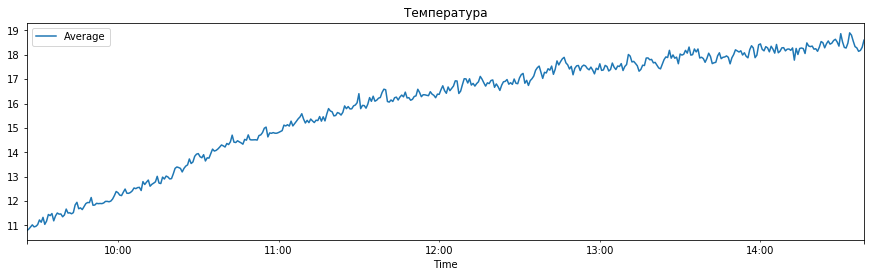

In [425]:

res = (df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Температура'].mean().reset_index(name='Average'))
res.plot(x='Time', y='Average',title='Температура',figsize=(15,4))

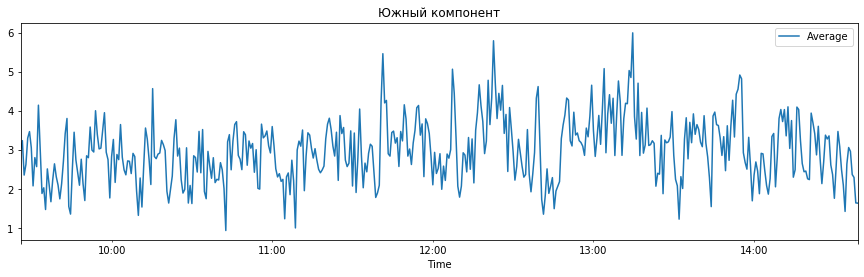

In [426]:
res = (df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Южный компонент'].mean().reset_index(name='Average'))
res.plot(x='Time', y='Average',title='Южный компонент',figsize=(15,4))

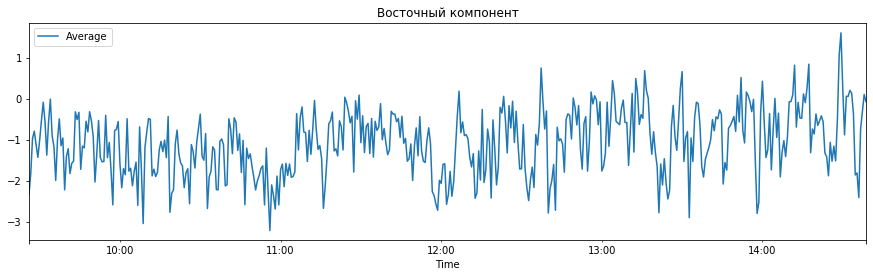

In [427]:
res = (df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Восточный компонент'].mean().reset_index(name='Average'))
res.plot(x='Time', y='Average',title='Восточный компонент',figsize=(15,4))

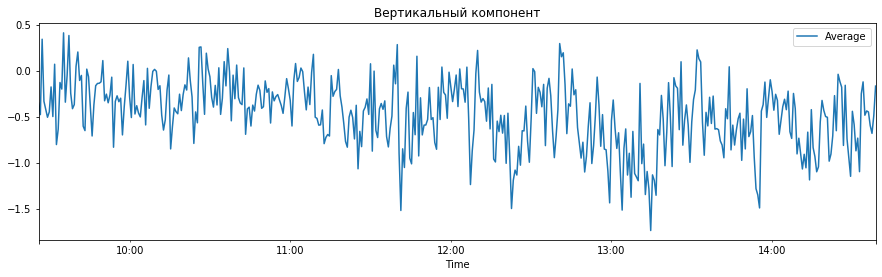

In [428]:
res = (df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Вертикальный компонент'].mean().reset_index(name='Average'))
res.plot(x='Time', y='Average',title='Вертикальный компонент',figsize=(15,4)) 

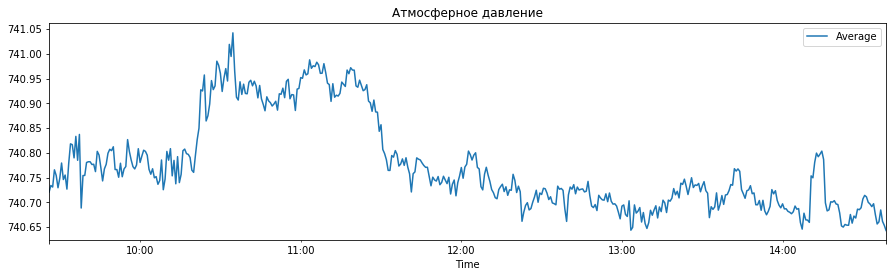

In [429]:
res = (df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Атмосферное давление'].mean().reset_index(name='Average'))
res.plot(x='Time', y='Average',title='Атмосферное давление',figsize=(15,4))

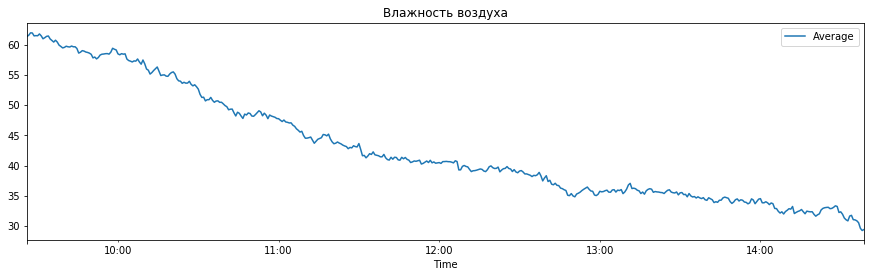

In [430]:
res = (df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Влажность воздуха'].mean().reset_index(name='Average'))
res.plot(x='Time', y='Average',title='Влажность воздуха',figsize=(15,4))